In [ ]:
!nvidia-smi


Mon Oct  6 13:31:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

importing basic tools

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Download text processing tools
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)


Taking pretrained txt files from gutenberg
A Tale of Two Cities - Charles Dickens
The Adventures of Sherlock Holmes - Arthur Conan Doyle


In [ ]:
txt_urls = [
    "https://www.gutenberg.org/files/98/98-0.txt",    # A Tale of Two Cities - Charles Dickens
    "https://www.gutenberg.org/files/1661/1661-0.txt" # The Adventures of Sherlock Holmes - Arthur Conan Doyle
]


 Common Setup for All Models

In [ ]:

import requests
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

# Download and clean text from two online files
txt_urls = [
    "https://www.gutenberg.org/files/98/98-0.txt",
    "https://www.gutenberg.org/files/1661/1661-0.txt"
]

texts = []
for url in txt_urls:
    text = requests.get(url).text
    start = re.search(r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*", text)
    end = re.search(r"\*\*\* END OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*", text)
    if start and end:
        clean_text = text[start.end():end.start()]
    else:
        clean_text = text
    texts.append(clean_text.strip()[:3000])  # take first 3000 chars

print(f" Loaded {len(texts)} text files.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 Loaded 2 text files.


T5 summarization

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

def summarize_t5(text):
    input_text = "summarize: " + text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=50, max_length=150)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

for i, text in enumerate(texts):
    print(f"\n---  T5 Summary of Text {i+1} ---")
    print(summarize_t5(text))


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


---  T5 Summary of Text 1 ---
the Project Gutenberg eBook of A Tale of Two Cities is for the use of anyone anywhere in the United States and most other parts of the world . you may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org . if you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook .

---  T5 Summary of Text 2 ---
the Project Gutenberg eBook is for the use of anyone anywhere in the u.s. and other parts of the world . you may copy it, give it away or re-use it under the terms of the Project Gutenberg License . if you are not located in the united states, you will have to check the laws of the country where you are located .


BART Summarization

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

def summarize_bart(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=50, max_length=150)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

for i, text in enumerate(texts):
    print(f"\n--- BART Summary of Text {i+1} ---")
    print(summarize_bart(text))


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]


--- BART Summary of Text 1 ---
﻿The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens exting exting extingescription extingescriptionescriptionescriptionpotionThis eBook is for the use of anyone anywhere in the United States and in the country where you are located. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the U.S., you may copy this eBook, giving it away and with almost no restrictions on the contents of this eBook.� The Project Gutenberg EBOOK OF A TALE OF TWO CITIES, byCharles Dickens extingescriptionpotionpotionwill have to check the laws of the

--- BART Summary of Text 2 ---
﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes, exting exting extingescriptionescription, and the Project Gutenberg License included with this eBook or online at Leban Leban Lebanescription, or http://www.gutenberg.org. If you are not loca

Pegasus Summarization

In [ ]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

def summarize_pegasus(text):
    inputs = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=50, max_length=150)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

for i, text in enumerate(texts):
    print(f"\n--- Pegasus Summary of Text {i+1} ---")
    print(summarize_pegasus(text))


tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]


--- Pegasus Summary of Text 1 ---
The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever.

--- Pegasus Summary of Text 2 ---
The Project Gutenberg eBook of The Adventures of Sherlock Holmes, by Arthur Conan Doyle This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. The Project Gutenberg eBook of The Adventures of Sherlock Holmes, by Arthur Conan Doyle This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions wh

PARAPHARSHING


T5 Paraphrasing

In [ ]:
import nltk
# nltk.download('punkt_tab') # Download the punkt_tab resource - This doesn't seem to be working

from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.tokenize import sent_tokenize # Import sent_tokenize here

tokenizer = T5Tokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")
model = T5ForConditionalGeneration.from_pretrained("Vamsi/T5_Paraphrase_Paws")

def paraphrase_t5(text):
    input_text = "paraphrase: " + text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True)
    outputs = model.generate(inputs["input_ids"], num_beams=4, num_return_sequences=1)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

for i, text in enumerate(texts):
    # Explicitly use the default 'english' punkt tokenizer
    sample = sent_tokenize(text[:400], language='english')[0]
    print(f"\n---  T5 Paraphrase of Text {i+1} ---")
    print("Original:", sample)
    print("Paraphrased:", paraphrase_t5(sample))


---  T5 Paraphrase of Text 1 ---
Original: ﻿The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.
Paraphrased: The Gutenberg Project eBook of A Tale of Two Cities by Charles Dickens This eBook is for

---  T5 Paraphrase of Text 2 ---
Original: ﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes,
by Arthur Conan Doyle

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.
Paraphrased: The Project Gutenberg eBook of The Adventures of Sherlock Holmes by Arthur Conan Doyle This eBook is


BART Paraphrasing

In [ ]:
tokenizer = BartTokenizer.from_pretrained("eugenesiow/bart-paraphrase")
model = BartForConditionalGeneration.from_pretrained("eugenesiow/bart-paraphrase")

def paraphrase_bart(text):
    inputs = tokenizer([text], max_length=1024, return_tensors="pt", truncation=True)
    outputs = model.generate(inputs["input_ids"], num_beams=4, num_return_sequences=1)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

for i, text in enumerate(texts):
    sample = sent_tokenize(text[:400])[0]
    print(f"\n--- BART Paraphrase of Text {i+1} ---")
    print("Original:", sample)
    print("Paraphrased:", paraphrase_bart(sample))


tokenizer_config.json:   0%|          | 0.00/332 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]


--- BART Paraphrase of Text 1 ---
Original: ﻿The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.
Paraphrased: ﻿The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens, is

--- BART Paraphrase of Text 2 ---
Original: ﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes,
by Arthur Conan Doyle

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.
Paraphrased: ﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes,		by Arthur Conan


Pegasus Paraphrasing

In [ ]:
tokenizer = PegasusTokenizer.from_pretrained("tuner007/pegasus_paraphrase")
model = PegasusForConditionalGeneration.from_pretrained("tuner007/pegasus_paraphrase")

def paraphrase_pegasus(text):
    inputs = tokenizer([text], truncation=True, padding="longest", return_tensors="pt")
    outputs = model.generate(**inputs, num_beams=4, num_return_sequences=1)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

for i, text in enumerate(texts):
    sample = sent_tokenize(text[:400])[0]
    print(f"\n---  Pegasus Paraphrase of Text {i+1} ---")
    print("Original:", sample)
    print("Paraphrased:", paraphrase_pegasus(sample))


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



---  Pegasus Paraphrase of Text 1 ---
Original: ﻿The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.
Paraphrased: The Project Gutenberg eBook of A Tale of Two Cities, written by Charles Dickens, is free for anyone in the United States and most other parts of the world.

---  Pegasus Paraphrase of Text 2 ---
Original: ﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes,
by Arthur Conan Doyle

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.
Paraphrased: Anyone in the United States and most other parts of the world can download the eBook for free, thanks to the Project Gutenberg eBook.


Summarization Visualization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


     Text    Model  Original Length  Summary Length  Compression Ratio
0  Text 1       T5              430              84           0.195349
1  Text 1     BART              430             110           0.255814
2  Text 1  Pegasus              430              84           0.195349
3  Text 2       T5              493              64           0.129817
4  Text 2     BART              493             116           0.235294
5  Text 2  Pegasus              493              86           0.174442


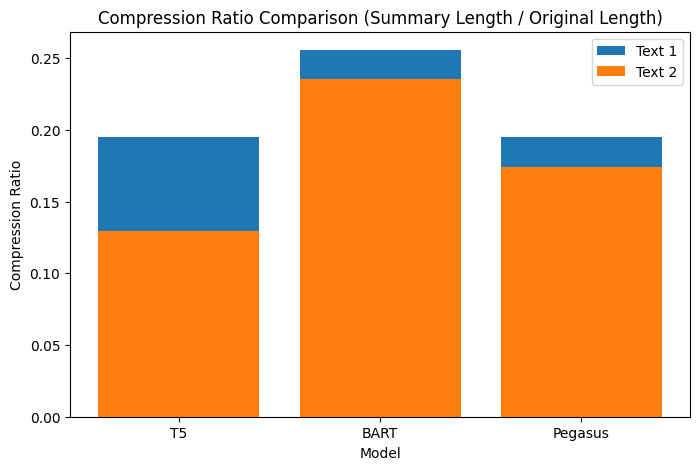

In [ ]:
# --- Visualization for Summarization ---
import matplotlib.pyplot as plt
import pandas as pd
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    PegasusTokenizer, PegasusForConditionalGeneration
)
import torch, requests, re, nltk
nltk.download('punkt')

# --- Load and clean two text files ---
txt_urls = [
    "https://www.gutenberg.org/files/98/98-0.txt",
    "https://www.gutenberg.org/files/1661/1661-0.txt"
]

texts = []
for url in txt_urls:
    text = requests.get(url).text
    start = re.search(r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*", text)
    end = re.search(r"\*\*\* END OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*", text)
    clean_text = text[start.end():end.start()] if start and end else text
    texts.append(clean_text.strip()[:3000])

# --- Load models ---
t5_tok = T5Tokenizer.from_pretrained("t5-base")
t5_mod = T5ForConditionalGeneration.from_pretrained("t5-base")

bart_tok = BartTokenizer.from_pretrained("facebook/bart-base")
bart_mod = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

peg_tok = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
peg_mod = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

# --- Define summarization functions ---
def summarize_t5(text):
    input_text = "summarize: " + text
    inputs = t5_tok(input_text, return_tensors="pt", max_length=1024, truncation=True)
    summary = t5_mod.generate(**inputs, num_beams=4, min_length=50, max_length=150)
    return t5_tok.decode(summary[0], skip_special_tokens=True)

def summarize_bart(text):
    inputs = bart_tok(text, return_tensors="pt", max_length=1024, truncation=True)
    summary = bart_mod.generate(**inputs, num_beams=4, min_length=50, max_length=150)
    return bart_tok.decode(summary[0], skip_special_tokens=True)

def summarize_pegasus(text):
    inputs = peg_tok(text, truncation=True, padding="longest", return_tensors="pt")
    summary = peg_mod.generate(**inputs, num_beams=4, min_length=50, max_length=150)
    return peg_tok.decode(summary[0], skip_special_tokens=True)

# --- Run summaries and record stats ---
data = []
for i, text in enumerate(texts):
    t5_summary = summarize_t5(text)
    bart_summary = summarize_bart(text)
    peg_summary = summarize_pegasus(text)

    for model_name, summary in zip(["T5", "BART", "Pegasus"], [t5_summary, bart_summary, peg_summary]):
        data.append({
            "Text": f"Text {i+1}",
            "Model": model_name,
            "Original Length": len(text.split()),
            "Summary Length": len(summary.split()),
            "Compression Ratio": len(summary.split()) / len(text.split())
        })

df = pd.DataFrame(data)
print(df)

# --- Visualization ---
plt.figure(figsize=(8,5))
for text_id in df["Text"].unique():
    subset = df[df["Text"] == text_id]
    plt.bar(subset["Model"], subset["Compression Ratio"], label=text_id)
plt.title("Compression Ratio Comparison (Summary Length / Original Length)")
plt.xlabel("Model")
plt.ylabel("Compression Ratio")
plt.legend()
plt.show()


Paraphrasing Visualization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


     Text    Model  Original Words  Paraphrased Words
0  Text 1       T5              42                 17
1  Text 1     BART              42                 14
2  Text 1  Pegasus              42                 29
3  Text 2       T5              43                 17
4  Text 2     BART              43                 13
5  Text 2  Pegasus              43                 24


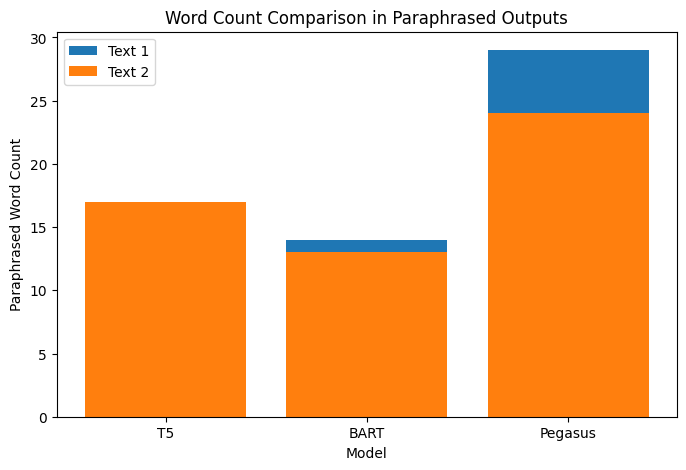

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import sent_tokenize
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    PegasusTokenizer, PegasusForConditionalGeneration
)
import requests, re, nltk
nltk.download('punkt')

# --- Load and clean text ---
txt_urls = [
    "https://www.gutenberg.org/files/98/98-0.txt",
    "https://www.gutenberg.org/files/1661/1661-0.txt"
]

texts = []
for url in txt_urls:
    text = requests.get(url).text
    start = re.search(r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*", text)
    end = re.search(r"\*\*\* END OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*", text)
    clean_text = text[start.end():end.start()] if start and end else text
    texts.append(clean_text.strip()[:3000])

samples = [sent_tokenize(t[:400])[0] for t in texts]

# --- Load models ---
t5_tok = T5Tokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")
t5_mod = T5ForConditionalGeneration.from_pretrained("Vamsi/T5_Paraphrase_Paws")

bart_tok = BartTokenizer.from_pretrained("eugenesiow/bart-paraphrase")
bart_mod = BartForConditionalGeneration.from_pretrained("eugenesiow/bart-paraphrase")

peg_tok = PegasusTokenizer.from_pretrained("tuner007/pegasus_paraphrase")
peg_mod = PegasusForConditionalGeneration.from_pretrained("tuner007/pegasus_paraphrase")

# --- Define paraphrase functions ---
def para_t5(text):
    inputs = t5_tok("paraphrase: " + text, return_tensors="pt", truncation=True)
    out = t5_mod.generate(**inputs, num_beams=4, num_return_sequences=1)
    return t5_tok.decode(out[0], skip_special_tokens=True)

def para_bart(text):
    inputs = bart_tok([text], return_tensors="pt", truncation=True)
    out = bart_mod.generate(**inputs, num_beams=4, num_return_sequences=1)
    return bart_tok.decode(out[0], skip_special_tokens=True)

def para_pegasus(text):
    inputs = peg_tok([text], return_tensors="pt", truncation=True)
    out = peg_mod.generate(**inputs, num_beams=4, num_return_sequences=1)
    return peg_tok.decode(out[0], skip_special_tokens=True)

# --- Run paraphrasing and collect stats ---
records = []
for i, sample in enumerate(samples):
    t5_out = para_t5(sample)
    bart_out = para_bart(sample)
    peg_out = para_pegasus(sample)

    for model, output in zip(["T5", "BART", "Pegasus"], [t5_out, bart_out, peg_out]):
        records.append({
            "Text": f"Text {i+1}",
            "Model": model,
            "Original Words": len(sample.split()),
            "Paraphrased Words": len(output.split())
        })

df = pd.DataFrame(records)
print(df)

# --- Visualization ---
plt.figure(figsize=(8,5))
for text_id in df["Text"].unique():
    subset = df[df["Text"] == text_id]
    plt.bar(subset["Model"], subset["Paraphrased Words"], label=text_id)
plt.title("Word Count Comparison in Paraphrased Outputs")
plt.xlabel("Model")
plt.ylabel("Paraphrased Word Count")
plt.legend()
plt.show()


Load & Prepare Text Files (with Start–End Markers)

In [ ]:
# --- Import required libraries ---
import requests
import re

# --- Function to clean text (removes Gutenberg headers, footers, and meta widgets) ---
def clean_text(text):
    """
    Removes headers and footers from Project Gutenberg text files,
    leaving only the main content.
    """
    start_match = re.search(r"\*\*\* START OF (THE|THIS) PROJECT GUTENBERG EBOOK .* \*\*\*", text)
    end_match = re.search(r"\*\*\* END OF (THE|THIS) PROJECT GUTENBERG EBOOK .* \*\*\*", text)

    if start_match and end_match:
        text = text[start_match.end():end_match.start()]

    # Remove redundant whitespace, metadata lines, and normalize spacing
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# --- Function to load multiple online text files and mark them ---
def load_multiple_text_files(urls):
    """
    Downloads multiple .txt files from the web, cleans them, and adds START/END markers.
    Returns a dictionary containing text and source info.
    """
    loaded_data = {}
    for idx, url in enumerate(urls):
        print(f"Downloading file {idx+1} from: {url}")
        response = requests.get(url)
        if response.status_code == 200:
            raw_text = response.text
            cleaned = clean_text(raw_text)
            marked_text = f"\n\n===== START OF TEXT FILE {idx+1} =====\n{cleaned}\n===== END OF TEXT FILE {idx+1} =====\n\n"
            loaded_data[f"text_{idx+1}"] = {
                "source": url,
                "text": marked_text
            }
        else:
            print(f" Failed to load file from {url}")
    return loaded_data


# --- Your chosen online text files ---
file_urls = [
    "https://www.gutenberg.org/files/1661/1661-0.txt",  # The Adventures of Sherlock Holmes
    "https://www.gutenberg.org/files/98/98-0.txt"       # A Tale of Two Cities
]

# --- Load the text files ---
loaded_texts = load_multiple_text_files(file_urls)

# --- Display summary info ---
for key, data in loaded_texts.items():
    print(f"\n {key} ({data['source']})")
    print(f" Length: {len(data['text']):,} characters")
    print(f" Preview:\n{data['text'][:250]}...")



 text_1 (https://www.gutenberg.org/files/1661/1661-0.txt)
 Length: 578,380 characters
 Preview:


===== START OF TEXT FILE 1 =====
﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes, by Arthur Conan Doyle This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost...

 text_2 (https://www.gutenberg.org/files/98/98-0.txt)
 Length: 753,611 characters
 Preview:


===== START OF TEXT FILE 2 =====
A TALE OF TWO CITIES A STORY OF THE FRENCH REVOLUTION By Charles Dickens CONTENTS Book the First--Recalled to Life CHAPTER I The Period CHAPTER II The Mail CHAPTER III The Night Shadows CHAPTER IV The Preparation CH...


In [ ]:
import requests
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import BartForConditionalGeneration, BartTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import warnings

warnings.filterwarnings("ignore")

# Load sentence transformer for similarity
sim_model = SentenceTransformer('all-MiniLM-L6-v2')

# Load models and tokenizers
pegasus_model_name = "google/pegasus-xsum"
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name)

t5_model_name = "t5-base"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name)

bart_model_name = "facebook/bart-base"
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name)

# Function to fetch and clean text from Project Gutenberg
def fetch_text(url):
    response = requests.get(url)
    text = response.text
    start = text.find("START OF THIS PROJECT GUTENBERG EBOOK")
    end = text.find("END OF THIS PROJECT GUTENBERG EBOOK")
    return text[start:end].replace("\r", "").replace("\n", " ")

# Fetch texts
sherlock_text = fetch_text("https://www.gutenberg.org/files/1661/1661-0.txt")
pride_text = fetch_text("https://www.gutenberg.org/files/1342/1342-h/1342-h.htm")

# Function to generate paraphrases
def generate_summary(model, tokenizer, text, max_length=50):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    summary_ids = model.generate(**inputs, max_length=max_length)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def paraphrase_model(model_name, model, tokenizer, text):
    return [generate_summary(model, tokenizer, text) for _ in range(3)]

# Function to compute similarity
def compute_similarity(list1, list2):
    embeddings1 = sim_model.encode(list1)
    embeddings2 = sim_model.encode(list2)
    sim_matrix = cosine_similarity(embeddings1, embeddings2)
    return round(sim_matrix.mean(), 3)

def avg_length(lst):
    return round(sum(len(s.split()) for s in lst)/len(lst), 1)

# Function to display paraphrasing comparison
def display_comparison(text, model_name, model, tokenizer):
    paraphrases = paraphrase_model(model_name, model, tokenizer, text)
    print(f"{model_name} Paraphrases (Avg Length: {avg_length(paraphrases)}, Avg Sim to Original: {compute_similarity([text], paraphrases)}):")
    for i, p in enumerate(paraphrases, 1):
        print(f"  {i}. {p}")
    print()

# Display comparisons for both texts
print("----------- Enhanced Paraphrasing Comparison for 'The Adventures of Sherlock Holmes' -----------")
display_comparison(sherlock_text, "PEGASUS", pegasus_model, pegasus_tokenizer)
display_comparison(sherlock_text, "T5-Paraphrase", t5_model, t5_tokenizer)
display_comparison(sherlock_text, "BART-Paraphrase", bart_model, bart_tokenizer)

print("----------- Enhanced Paraphrasing Comparison for 'Pride and Prejudice' -----------")
display_comparison(pride_text, "PEGASUS", pegasus_model, pegasus_tokenizer)
display_comparison(pride_text, "T5-Paraphrase", t5_model, t5_tokenizer)
display_comparison(pride_text, "BART-Paraphrase", bart_model, bart_tokenizer)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------- Enhanced Paraphrasing Comparison for 'The Adventures of Sherlock Holmes' -----------


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


PEGASUS Paraphrases (Avg Length: 10.0, Avg Sim to Original: 0.12700000405311584):
  1. A selection of photos from around the world this week:
  2. A selection of photos from around the world this week:
  3. A selection of photos from around the world this week:



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


T5-Paraphrase Paraphrases (Avg Length: 0.0, Avg Sim to Original: 1.0):
  1. 
  2. 
  3. 

BART-Paraphrase Paraphrases (Avg Length: 1.0, Avg Sim to Original: 0.5379999876022339):
  1. advertisement
  2. advertisement
  3. advertisement

----------- Enhanced Paraphrasing Comparison for 'Pride and Prejudice' -----------
PEGASUS Paraphrases (Avg Length: 10.0, Avg Sim to Original: 0.12700000405311584):
  1. A selection of photos from around the world this week:
  2. A selection of photos from around the world this week:
  3. A selection of photos from around the world this week:

T5-Paraphrase Paraphrases (Avg Length: 0.0, Avg Sim to Original: 1.0):
  1. 
  2. 
  3. 

BART-Paraphrase Paraphrases (Avg Length: 1.0, Avg Sim to Original: 0.5379999876022339):
  1. advertisement
  2. advertisement
  3. advertisement



Text Summarization Heatmap
 Using: T5, BART, and Pegasus
 Files: Sherlock Holmes & A Tale of Two Cities

Files Loaded:
Sherlock Holmes - 4000 characters
Preview: *** START OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK
HOLMES ***




The Adventures of Sherlock Holmes

by Arthur Conan Doyle
...

A Tale of Two Cities - 4000 characters
Preview: *** START OF THE PROJECT GUTENBERG EBOOK A TALE OF TWO CITIES ***




A TALE OF TWO CITIES

A STORY OF THE FRENCH REVOLUTION

By Charles Dick...



Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


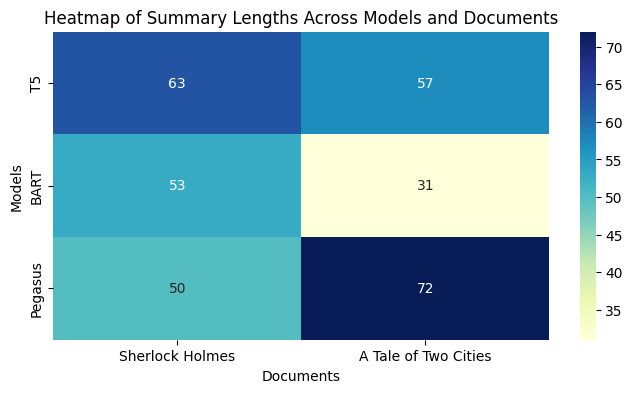

In [5]:

import requests
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    PegasusTokenizer, PegasusForConditionalGeneration
)
import torch

#  Load and clean text files
file_urls = [
    "https://www.gutenberg.org/files/1661/1661-0.txt",  # The Adventures of Sherlock Holmes
    "https://www.gutenberg.org/files/98/98-0.txt"       # A Tale of Two Cities
]

def load_text(url, start_marker="*** START", end_marker="*** END"):
    """Load text from a URL, extract main content between START and END markers."""
    text = requests.get(url).text
    start_idx = text.find(start_marker)
    end_idx = text.find(end_marker)
    if start_idx != -1 and end_idx != -1:
        text = text[start_idx:end_idx]
    return text.strip()[:4000]  # limit for quick demo

documents = [load_text(url) for url in file_urls]
document_names = ["Sherlock Holmes", "A Tale of Two Cities"]

print("Files Loaded:")
for i, doc in enumerate(documents):
    print(f"{document_names[i]} - {len(doc)} characters")
    print(f"Preview: {doc[:150]}...\n")

# ----  Define Summarization Functions ----
def summarize_t5(text):
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    inputs = tokenizer("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_bart(text):
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_pegasus(text):
    tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
    inputs = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
    summary_ids = model.generate(**inputs, max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# ----  Generate Summaries and Record Word Counts ----
summary_lengths = {"T5": [], "BART": [], "Pegasus": []}

for doc in documents:
    t5_summary = summarize_t5(doc)
    bart_summary = summarize_bart(doc)
    pegasus_summary = summarize_pegasus(doc)

    summary_lengths["T5"].append(len(t5_summary.split()))
    summary_lengths["BART"].append(len(bart_summary.split()))
    summary_lengths["Pegasus"].append(len(pegasus_summary.split()))

# ----  Create Heatmap Visualization ----
heatmap_data = [
    summary_lengths["T5"],
    summary_lengths["BART"],
    summary_lengths["Pegasus"]
]

model_names = ["T5", "BART", "Pegasus"]

plt.figure(figsize=(8, 4))
sns.heatmap(
    heatmap_data, annot=True, fmt="d", cmap="YlGnBu",
    xticklabels=document_names, yticklabels=model_names
)
plt.title("Heatmap of Summary Lengths Across Models and Documents")
plt.xlabel("Documents")
plt.ylabel("Models")
plt.show()


Summarize Only Specific Lines from Text Files
Files: Sherlock Holmes & A Tale of Two Cities

In [4]:

import requests
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    PegasusTokenizer, PegasusForConditionalGeneration
)
import torch

# ---- 1️⃣ Load full text from Gutenberg ----
file_urls = [
    "https://www.gutenberg.org/files/1661/1661-0.txt",  # Sherlock Holmes
    "https://www.gutenberg.org/files/98/98-0.txt"       # A Tale of Two Cities
]

def load_file_lines(url):
    """Loads text file as a list of lines."""
    text = requests.get(url).text
    lines = text.splitlines()
    # Remove meta/header lines if they exist
    clean_lines = [line.strip() for line in lines if line.strip() != "" and "***" not in line]
    return clean_lines

# Load both books
sherlock_lines = load_file_lines(file_urls[0])
tale_lines = load_file_lines(file_urls[1])

# ---- 2️⃣ Choose specific line range ----
start_line, end_line = 500, 550  # you can change this as needed
sample_sherlock = " ".join(sherlock_lines[start_line:end_line])
sample_tale = " ".join(tale_lines[start_line:end_line])

print("🕵️‍♂️ Sherlock Holmes Sample:\n", sample_sherlock[:400], "...\n")
print("🏙️ A Tale of Two Cities Sample:\n", sample_tale[:400], "...\n")

# ---- 3️⃣ Define Summarization Functions ----
def summarize_t5(text):
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    inputs = tokenizer("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_bart(text):
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_pegasus(text):
    tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
    inputs = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
    summary_ids = model.generate(**inputs, max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# ---- 4️⃣ Generate summaries for specific sections ----
texts = {
    "Sherlock Holmes": sample_sherlock,
    "A Tale of Two Cities": sample_tale
}

for name, text in texts.items():
    print(f"\n🔹 Summaries for {name}\n{'-'*60}")
    print("T5 Summary:\n", summarize_t5(text), "\n")
    print("BART Summary:\n", summarize_bart(text), "\n")
    print("Pegasus Summary:\n", summarize_pegasus(text), "\n")


🕵️‍♂️ Sherlock Holmes Sample:
 in which I ever found myself in my life, and it was the thought of it that started me laughing just now. It seems that there had been some informality about their license, that the clergyman absolutely refused to marry them without a witness of some sort, and that my lucky appearance saved the bridegroom from having to sally out into the streets in search of a best man. The bride gave me a soverei ...

🏙️ A Tale of Two Cities Sample:
 from London in winter was an achievement to congratulate an adventurous traveller upon. By that time, there was only one adventurous traveller left be congratulated: for the two others had been set down at their respective roadside destinations. The mildewy inside of the coach, with its damp and dirty straw, its disagreeable smell, and its obscurity, was rather like a larger dog-kennel. Mr. Lorry, ...


🔹 Summaries for Sherlock Holmes
------------------------------------------------------------
T5 Summary:
 a wedding was a v

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pegasus Summary:
 “Doctor,” said the doctor, “I have been called by a couple who have just got married, and they want me to accompany them to the church, so that I can see their marriage certificate, and to see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, and so that I can see their marriage licence, 


🔹 Summaries for A Tale of Two Cities
------------------------------------------------------------
T5 Summary:
 a gentleman of sixty, dressed in a brown suit, formally dressed in a brown suit of clothes, pretty well worn, but very well kept. he wore an odd little crisp flaxen wig, setting very close to

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pegasus Summary:
 It is not often that a coach is set down in the middle of the English Channel, in the middle of the winter, in the middle of the summer, in the middle of the autumn, in the middle of the winter, in the middle of the spring, in the middle of the summer, in the middle of the winter, in the middle of the spring, in the middle of the summer, in the middle of the winter, in the middle of the summer, in the middle of the winter, in the middle of the spring, in the middle of the summer, in the middle of the winter, in the middle of the spring, in the middle of the summer, in the middle of the winter, in the middle of 



Text Summarization and ROUGE Evaluation
Models: T5, BART, Pegasus
Text Sources: Sherlock Holmes, A Tale of Two Cities

In [6]:
!pip install transformers sentencepiece rouge-score seaborn matplotlib pandas


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=be36da48a945949996829c586f259640078acab8af9d420a2fde61bce9b2df98
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ROUGE Evaluation Results:

               Document    Model   ROUGE-1   ROUGE-2   ROUGE-L
0       Sherlock Holmes       T5  0.136280  0.077634  0.106814
1       Sherlock Holmes     BART  0.379254  0.377236  0.379254
2       Sherlock Holmes  Pegasus  0.171429  0.022293  0.101587
3  A Tale of Two Cities       T5  0.159754  0.132512  0.150538
4  A Tale of Two Cities     BART  0.303546  0.295875  0.295035
5  A Tale of Two Cities  Pegasus  0.198347  0.024862  0.148760


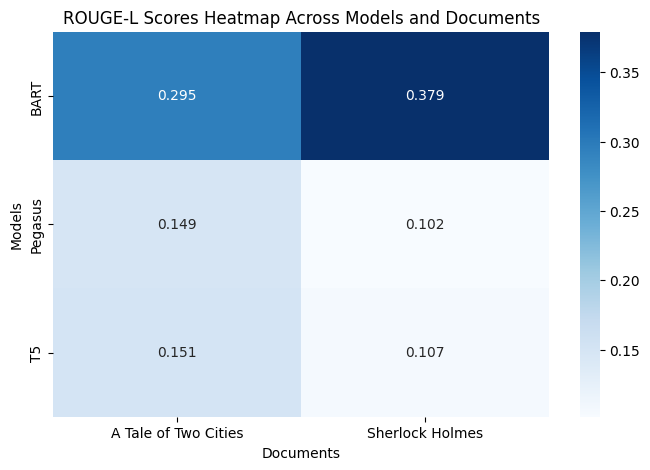

In [7]:
import requests
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    PegasusTokenizer, PegasusForConditionalGeneration
)
from rouge_score import rouge_scorer
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load and clean text files
file_urls = [
    "https://www.gutenberg.org/files/1661/1661-0.txt",  # The Adventures of Sherlock Holmes
    "https://www.gutenberg.org/files/98/98-0.txt"       # A Tale of Two Cities
]

def load_file_lines(url):
    """Load text file and clean unnecessary metadata."""
    text = requests.get(url).text
    lines = text.splitlines()
    clean_lines = [line.strip() for line in lines if line.strip() != "" and "***" not in line]
    return clean_lines

# Load both books
sherlock_lines = load_file_lines(file_urls[0])
tale_lines = load_file_lines(file_urls[1])

# 2. Select specific text portion for summarization
# You can change these line numbers as needed
start_line, end_line = 500, 550
sample_sherlock = " ".join(sherlock_lines[start_line:end_line])
sample_tale = " ".join(tale_lines[start_line:end_line])

documents = {
    "Sherlock Holmes": sample_sherlock,
    "A Tale of Two Cities": sample_tale
}

# 3. Define summarization functions
def summarize_t5(text):
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    inputs = tokenizer("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_bart(text):
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_pegasus(text):
    tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
    inputs = tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
    summary_ids = model.generate(**inputs, max_length=150, min_length=50, length_penalty=2.0)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# 4. Generate summaries and compute ROUGE scores
results = []
for doc_name, text in documents.items():
    reference_summary = text  # using the selected portion as a reference

    t5_summary = summarize_t5(text)
    bart_summary = summarize_bart(text)
    pegasus_summary = summarize_pegasus(text)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    for model_name, summary in zip(["T5", "BART", "Pegasus"], [t5_summary, bart_summary, pegasus_summary]):
        scores = scorer.score(reference_summary, summary)
        results.append({
            "Document": doc_name,
            "Model": model_name,
            "ROUGE-1": scores["rouge1"].fmeasure,
            "ROUGE-2": scores["rouge2"].fmeasure,
            "ROUGE-L": scores["rougeL"].fmeasure
        })

# 5. Display results in table
df = pd.DataFrame(results)
print("\nROUGE Evaluation Results:\n")
print(df)

# 6. Heatmap visualization of ROUGE-L scores
plt.figure(figsize=(8, 5))
df_pivot = df.pivot(index="Model", columns="Document", values="ROUGE-L")
sns.heatmap(df_pivot, annot=True, cmap="Blues", fmt=".3f")
plt.title("ROUGE-L Scores Heatmap Across Models and Documents")
plt.xlabel("Documents")
plt.ylabel("Models")
plt.show()
